# PROJECT MACHINE LEARNING (STAGE 3) - MATHIEU COWAN, ALARIC DE BASTARD, ADRIEN DE MAILLY NESLE (DIA 3)

*Caution : The run of the models is very long for part 1 and part 2 (first approach) because we use a hyperparameters grid with many combinations*

#### Importations

In [718]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import numpy as np
import pandas as pd
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import DBSCAN, MeanShift
import os
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from itertools import product
import os
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from itertools import product

#### Importation of the csv

In [721]:
df1 = pd.read_csv("Online_Retail.csv", sep=';', encoding='ISO-8859-1')

#### Data pre-processing

In [723]:
df1['UnitPrice'] = df1['UnitPrice'].astype(str).str.replace(',', '.').astype(float)
df1[df1['UnitPrice'] < 0]
df1['Revenue'] = df1['Quantity'] * df1['UnitPrice']
df1 = df1[df1['Description'].notnull()]
#df1 = df1[df1['InvoiceNo'].str[0] != 'C']
df1 = df1[df1['UnitPrice']>0]
df1 = df1[df1['Quantity']>0]
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'], format="%d/%m/%Y %H:%M")
'''
start_date = "2010-11-01"
end_date = "2010-12-31"
df1 = df1[(df1['InvoiceDate'] >= start_date) & (df1['InvoiceDate'] <= end_date)]'''
df1 = df1[df1['Country'] == 'Germany']
description_counts = df1['Description'].value_counts()
descriptions_to_keep = description_counts[description_counts > 1].index
df1 = df1.drop_duplicates()
df1['Description'] = df1['Description'].replace(',', ' ', regex=True)
df1['CustomerID'] = df1['CustomerID'].fillna(-1)
df1['CustomerID'] = df1['CustomerID'].astype(int)
# drop les customerID = -1
df1 = df1[df1['CustomerID'] != -1]
df1["CustomerID"] = df1["CustomerID"].astype(str).apply(lambda x: x.split('.')[0])
df1["InvoiceDate"] = pd.to_datetime(df1["InvoiceDate"], dayfirst=True).dt.date

We check that there is no negative value in the revenue column so that it does not affect this stage

In [725]:
negcount = (df1['Revenue'] < 0).sum() #just in case we check the number of negative values, count mess up our calculations
print(f"number of negative values : {negcount}")

number of negative values : 0


In [729]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
1109,536527,22809,SET OF 6 T-LIGHTS SANTA,6,2010-12-01,2.95,12662,Germany,17.7
1110,536527,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,6,2010-12-01,2.55,12662,Germany,15.3
1111,536527,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12,2010-12-01,0.85,12662,Germany,10.2
1112,536527,22242,5 HOOK HANGER MAGIC TOADSTOOL,12,2010-12-01,1.65,12662,Germany,19.8
1113,536527,22244,3 HOOK HANGER MAGIC GARDEN,12,2010-12-01,1.95,12662,Germany,23.4


In [731]:
print(f"Number of rows of the portion of the dataframe we will use here : {len(df1)}")

Number of rows of the portion of the dataframe we will use here : 9025


## First prediction : Prediction of the revenue with the description (embedding) of the products for the 2010 Germany transactions with linear regression

##### Here, we will use the MLPRegressor model to make prediction on the part of the dataset described above.

Just like for the previous steps, we will use the embeddings on the description of the products. However we will see that we will apply to those embeddings way more appropriate models.

In [736]:
sentence_model = SentenceTransformer('all-MiniLM-L12-v2')
embeddings = sentence_model.encode(df1['Description'].tolist(), show_progress_bar=True)
y = df1['Revenue']

Batches:   0%|          | 0/283 [00:00<?, ?it/s]

In [265]:
results_reg_file = "newresults_reg.csv" #we define a CSV where we will stock our results

if os.path.exists(results_reg_file): #check if file exists, if not we create the file with the associated columns
    results_reg_df = pd.read_csv(results_reg_file)
else:
    results_reg_df = pd.DataFrame(columns=[
        "Type de modèle", "Hyperparamètres du modèle", "Temps d'entraînement", 
        "Temps d'inférence", "RMSE train", "RMSE test", "MAE train", "MAE test"
    ])

# Function to evaluate the model for regression
def evaluate_mlp_regressor(model, x_train, y_train, x_test, y_test, model_name, params):
    global results_reg_df

    #Training
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time

    #Train and test time
    start_time = time.time()
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    inference_time = time.time() - start_time

    #Metrics
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)) 
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    #Add results to the results dataframe
    results_reg_df = pd.concat([
        results_reg_df,
        pd.DataFrame([{
            "Type de modèle": model_name,
            "Hyperparamètres du modèle": params,
            "Temps d'entraînement": training_time,
            "Temps d'inférence": inference_time,
            "RMSE train": rmse_train,
            "RMSE test": rmse_test,
            "MAE train": mae_train,
            "MAE test": mae_test
        }])
    ], ignore_index=True)
    results_reg_df.to_csv(results_reg_file, index=False) #save to csv

#hyperparameters grid of MLP Regressor
mlp_param_grid = {
    "MLPRegressor": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],  #number of neurons per layer
        'activation': ['relu', 'tanh'],  #activation function
        'solver': ['adam', 'sgd'],  #optimisation function to update weights
        'alpha': [0.0001, 0.001, 0.01],  #help reducing overfitting
        'batch_size': ['auto', 32],  #Number of samples per batch
        'learning_rate': ['constant', 'adaptive'],  # Strategy for adjusting the learning rate
        'max_iter': [200, 500],  #Maximum number of iterations for training 
    }
}

mlp_regressor = MLPRegressor(random_state=42) #initialization of the MLPRegressor

#iteration through the grid to evaluate the model
for params in product(*mlp_param_grid["MLPRegressor"].values()):
    params_dict = dict(zip(mlp_param_grid["MLPRegressor"].keys(), params)) #initialization of the dictionnary
    mlp_regressor.set_params(**params_dict) #set the model parameters with the "current" combination of hyperparameters
    evaluate_mlp_regressor(mlp_regressor, X_train, y_train_reg, X_test, y_test_reg, "MLPRegressor", params_dict) #evaluation for train and test

In [329]:
results_file = "newresults_reg.csv" #we get the csv we created

if os.path.exists(results_file): #check if exists
    results_classif_df = pd.read_csv(results_file) #read the csv
else:
    #if file don't exist, create new dataframe with the appropriate columns
    results_classif_df = pd.DataFrame(columns=[
        "Type de modèle", "Hyperparamètres du modèle", "Temps d'entraînement", 
        "Temps d'inférence", "RMSE train", "RMSE test", "MAE train", "MAE test"
    ])
    
results_file #display

,Type de modèle,Hyperparamètres du modèle,Temps d'entraînement,Temps d'inférence,RMSE train,RMSE test,MAE train,MAE test
0,MLPRegressor,"{'hidden_layer_sizes': (50,), 'activation': 'r...",9.776629,0.009992,29.254133,36.709283,13.590787,16.160564
1,MLPRegressor,"{'hidden_layer_sizes': (50,), 'activation': 'r...",54.837816,0.122731,28.289910,37.027341,12.786750,15.975987
2,MLPRegressor,"{'hidden_layer_sizes': (50,), 'activation': 'r...",19.971381,0.016573,29.254133,36.709283,13.590787,16.160564
3,MLPRegressor,"{'hidden_layer_sizes': (50,), 'activation': 'r...",50.057751,0.081765,28.289910,37.027341,12.786750,15.975987
4,MLPRegressor,"{'hidden_layer_sizes': (50,), 'activation': 'r...",121.641189,0.204319,28.277503,36.999926,12.771362,15.959353
...,...,...,...,...,...,...,...,...
283,MLPRegressor,"{'hidden_layer_sizes': (50, 50), 'activation':...",24.484014,0.020052,27.542405,37.309605,11.753003,15.290126
284,MLPRegressor,"{'hidden_layer_sizes': (50, 50), 'activation':...",11.035056,0.015032,28.860227,36.685946,13.193916,15.578311
285,MLPRegressor,"{'hidden_layer_sizes': (50, 50), 'activation':...",10.749605,0.031251,28.860227,36.685946,13.193916,15.578311
286,MLPRegressor,"{'hidden_layer_sizes': (50, 50), 'activation':...",32.592857,0.016079,27.839337,37.397396,12.256947,15.502823


##### We now display the top two by RMSE test (ascending order) for each combinaison of the hyperparameters

In [332]:
results_classif_df.sort_values(by="RMSE test", ascending=True).head(2)

,Type de modèle,Hyperparamètres du modèle,Temps d'entraînement,Temps d'inférence,RMSE train,RMSE test,MAE train,MAE test
270,MLPRegressor,"{'hidden_layer_sizes': (50, 50), 'activation':...",31.569105,0.016106,28.386649,36.465481,12.653684,15.215993
48,MLPRegressor,"{'hidden_layer_sizes': (50,), 'activation': 't...",8.586038,0.022025,29.701729,36.489277,13.012154,15.461255


## Second Prediction : Classification of the revenue of each transaction in Germany in 2010 using Clusterisation prior to it

### First approach using manually initialized classes with manual clusterisation

Here we use LogisticRegression, MLPClassifier, RandomForestClassifier and SVC. We start by analysing better our data. To visualize and understand better the distribution of the value, we will use the logarithmic transformation of Germany's transactions

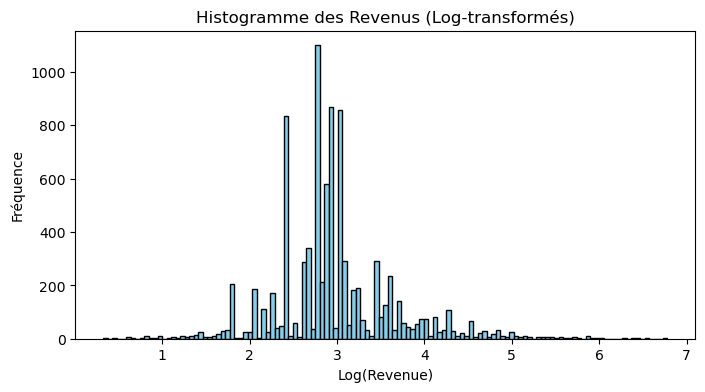

In [687]:
df1['LogRevenue'] = np.log(df1['Revenue'] + 1)  #Add of 1 to avoid log(0)
#We plot the histogram with 125 bins
plt.figure(figsize=(8,4))
plt.hist(df1['LogRevenue'], bins=125, color='skyblue', edgecolor='black')
plt.title('Histogramme des Revenus (Log-transformés)')
plt.xlabel('Log(Revenue)')
plt.ylabel('Fréquence')
plt.show()

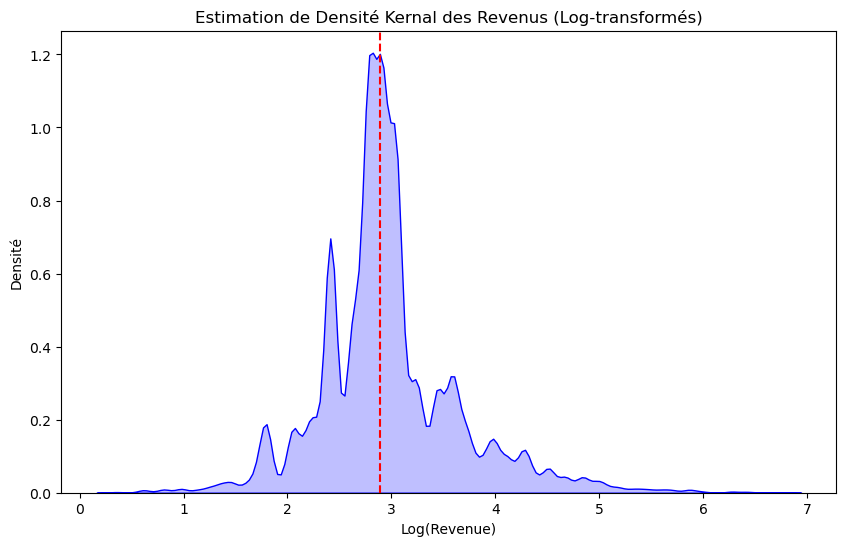

In [689]:
#plot of KDE
plt.figure(figsize=(10,6))
sns.kdeplot(df1['LogRevenue'], bw_adjust=0.5, fill=True, color='blue')
#Calculation of the quantile 0.5
quantile_50 = df1['LogRevenue'].quantile(0.50)
#identification of the quantile with a red vertical line
plt.axvline(x=quantile_50, color='red', linestyle='--', label=f'Quantile 0.5: {quantile_50:.2f}')
plt.title('Estimation de Densité Kernal des Revenus (Log-transformés)')
plt.xlabel('Log(Revenue)')
plt.ylabel('Densité')
plt.show()

In [691]:
quantiles = df1['LogRevenue'].quantile(0.5)  #we use q[0.5] to divide the data
bins = [df1['LogRevenue'].min(), quantiles, df1['LogRevenue'].max()]  #then we use two bins
labels = ['Faible', 'Élevé']  #two labels
df1['RevenueClass'] = pd.cut(df1['LogRevenue'], bins=bins, labels=labels, include_lowest=True)
print(df1['RevenueClass'].value_counts()) #display of the distribution

RevenueClass
Faible    4534
Élevé     4491
Name: count, dtype: int64


Here we believe that it is better to use the quartiles to do a classification, we believe that mathematically it is the most judicious thing to do.

At the beginning, we made tests of the models with four categories with the quantiles, but we saw that the results were better with 3 categories and even better with two, so we have here two categories which are split by q[0.5] (represented by the red line above].

In [693]:
#preparation of the data for the training
X = embeddings
y = df1['RevenueClass']

#80-20 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NB : the program has already been run because the code is stocked in results_classif2.csv we printed below (the code is long to run)

In [ ]:
#creation of csv for the results
results_classif_file = "results_classif2.csv"

#check if file exists, if not create it with the adpated columns
if os.path.exists(results_classif_file):
    results_classif_df = pd.read_csv(results_classif_file)
else:
    results_classif_df = pd.DataFrame(columns=[
        "Type de modèle", "Hyperparamètres du modèle", "Temps d'entraînement", 
        "Temps d'inférence", "Précision train", "Précision test", 
        "Recall train", "Recall test", "F1-Score train", "F1-Score test"
    ])

#evaluation of the classification models
def evaluate_classification_model(model, x_train, y_train, x_test, y_test, model_name, params):
    global results_classif_df

    #train
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time

    #time for train and test
    start_time = time.time()
    y_train_pred = model.predict(x_train)  # Predict train labels
    y_test_pred = model.predict(x_test)    # Predict test labels
    inference_time = time.time() - start_time

    #distinct classification reports
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    #store of the results
    results = {
        "Type de modèle": model_name,
        "Hyperparamètres du modèle": params,
        "Temps d'entraînement": training_time,
        "Temps d'inférence": inference_time,
        "Précision train": train_report["accuracy"],
        "Précision test": test_report["accuracy"],
        "Recall train": train_report["macro avg"]["recall"],
        "Recall test": test_report["macro avg"]["recall"],
        "F1-Score train": train_report["macro avg"]["f1-score"],
        "F1-Score test": test_report["macro avg"]["f1-score"]
    }
    # Append results to DataFrame
    results_classif_df = pd.concat([
        results_classif_df,
        pd.DataFrame([results])
    ], ignore_index=True)

    # Save to CSV
    results_classif_df.to_csv(results_classif_file, index=False)

#Hyperparameters grid for Logistic Regression, MLP, RandomForest, SVC
param_grid = {
   "LogisticRegression": {
        "C": [0.001, 0.01, 0.1, 1.0],  
        "penalty": ["l2"],  
        "solver": ["liblinear", "saga", "lbfgs"],
        "class_weight": [None, "balanced"],  
    },
    "MLPClassifier": {
        "hidden_layer_sizes": [(50,), (100,), (100, 50)],  
        "activation": ["relu", "tanh"],  
        "solver": ["adam", "sgd"],  
        "alpha": [0.0001, 0.001, 0.01],
        "early_stopping": [True, False],
    },
    "RandomForestClassifier": {
        "n_estimators": [50, 100, 200], 
        "max_depth": [10, 20, 30],  
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],  

    },
    "SVC": {
        "C": [0.01, 0.1, 1],  
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"], 
        "class_weight": ["balanced", None], 
    }
}

#Initialization of the logistic regression, MLP Classifier, RandomForest and SVC
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
mlp_model = MLPClassifier(max_iter=1000, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(random_state=42)

#iteration through the grid with the different hyperparameters of different models
#Logistic Regression
for params in product(*param_grid["LogisticRegression"].values()):
    params_dict = dict(zip(param_grid["LogisticRegression"].keys(), params))
    logreg_model.set_params(**params_dict)
    evaluate_classification_model(logreg_model, X_train_cls, y_train_cls, X_test_cls, y_test_cls, "LogisticRegression", params_dict)

#MLPClassifier
for params in product(*param_grid["MLPClassifier"].values()):
    params_dict = dict(zip(param_grid["MLPClassifier"].keys(), params))
    mlp_model.set_params(**params_dict)
    evaluate_classification_model(mlp_model, X_train_cls, y_train_cls, X_test_cls, y_test_cls, "MLPClassifier", params_dict)

#RandomForestClassifier
for params in product(*param_grid["RandomForestClassifier"].values()):
    params_dict = dict(zip(param_grid["RandomForestClassifier"].keys(), params))
    rf_model.set_params(**params_dict)
    evaluate_classification_model(rf_model, X_train_cls, y_train_cls, X_test_cls, y_test_cls, "RandomForestClassifier", params_dict)

#SVC
for params in product(*param_grid["SVC"].values()):
    params_dict = dict(zip(param_grid["SVC"].keys(), params))
    svm_model.set_params(**params_dict)
    evaluate_classification_model(svm_model, X_train_cls, y_train_cls, X_test_cls, y_test_cls, "SVC", params_dict)


In [402]:
#define file path to get the results
results_classif_file = "results_classif2.csv"

#check if file exist
if os.path.exists(results_classif_file):
    #read it as a dataframe
    results_classif_df = pd.read_csv(results_classif_file)
else:
    #if it doesn't exist, create the dataframe with the appropriate cols
    results_classif_df = pd.DataFrame(columns=[
        "Type de modèle", "Hyperparamètres du modèle", "Temps d'entraînement", 
        "Temps d'inférence", "Précision train", "Précision test", 
        "Recall train", "Recall test", "F1-Score train", "F1-Score test"
    ])

In [418]:
results_sorted = results_classif_df.sort_values( #fonction which sorts classification models with the metrics
    by=["F1-Score test", "Précision test", "Recall test"], 
    ascending=[False, False, False]
)
#we order the results of each result to compare models
mlp_top2 = results_sorted[results_sorted["Type de modèle"] == "MLPClassifier"].head(2)
logreg_top2 = results_sorted[results_sorted["Type de modèle"] == "LogisticRegression"].head(2)
RFC_top2 = results_sorted[results_sorted["Type de modèle"] == "RandomForestClassifier"].head(2)
SVC_top2 = results_sorted[results_sorted["Type de modèle"] == "SVC"].head(2)

#### Top 2 mlpclassifier results

In [421]:
mlp_top2

,Type de modèle,Hyperparamètres du modèle,Temps d'entraînement,Temps d'inférence,Précision train,Précision test,Recall train,Recall test,F1-Score train,F1-Score test
27,MLPClassifier,"{'hidden_layer_sizes': (50,), 'activation': 'r...",15.843364,0.011137,0.881163,0.823269,0.880487,0.824468,0.880696,0.823220
53,MLPClassifier,"{'hidden_layer_sizes': (100,), 'activation': '...",28.559687,0.114314,0.879224,0.819945,0.878477,0.821499,0.878666,0.819795


#### Top 2 logisticregressor results

In [424]:
logreg_top2

,Type de modèle,Hyperparamètres du modèle,Temps d'entraînement,Temps d'inférence,Précision train,Précision test,Recall train,Recall test,F1-Score train,F1-Score test
23,LogisticRegression,"{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs',...",0.122680,0.015877,0.771330,0.734072,0.770974,0.734950,0.771016,0.734054
21,LogisticRegression,"{'C': 1.0, 'penalty': 'l2', 'solver': 'saga', ...",0.797543,0.002641,0.770776,0.732964,0.770402,0.733938,0.770438,0.732928


#### Top 2 RandomForestClassifier results

In [427]:
RFC_top2

,Type de modèle,Hyperparamètres du modèle,Temps d'entraînement,Temps d'inférence,Précision train,Précision test,Recall train,Recall test,F1-Score train,F1-Score test
149,RandomForestClassifier,"{'n_estimators': 100, 'max_depth': 30, 'min_sa...",8.449174,0.188092,0.881856,0.818283,0.881100,0.820080,0.881298,0.818032
122,RandomForestClassifier,"{'n_estimators': 50, 'max_depth': 30, 'min_sam...",4.475769,0.114749,0.881579,0.817729,0.880919,0.819216,0.881131,0.817600


#### Top 2 SVC results

In [430]:
SVC_top2

,Type de modèle,Hyperparamètres du modèle,Temps d'entraînement,Temps d'inférence,Précision train,Précision test,Recall train,Recall test,F1-Score train,F1-Score test
197,SVC,"{'C': 1, 'kernel': 'rbf', 'gamma': 'scale', 'c...",8.839618,16.276094,0.866482,0.815512,0.865707,0.817193,0.865828,0.815308
198,SVC,"{'C': 1, 'kernel': 'rbf', 'gamma': 'scale', 'c...",8.997093,16.698116,0.866620,0.811634,0.865718,0.813588,0.865775,0.811291


##### We see here that the scores are better for the MLPClassifier, RandomForestClassifier and SVC, but MLP is a little bit better

### Second approach : Now we will try to do the same using models to do the clustering of this part of the dataset prior to the classification

Here we will attempt to use for this case DBSCAN and Mean Shift

DBSCAN

In [683]:
X = df1['Revenue'].values.reshape(-1, 1) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) #standardisation of the feature

We apply the DBSCAN model to the feature to clusterise it

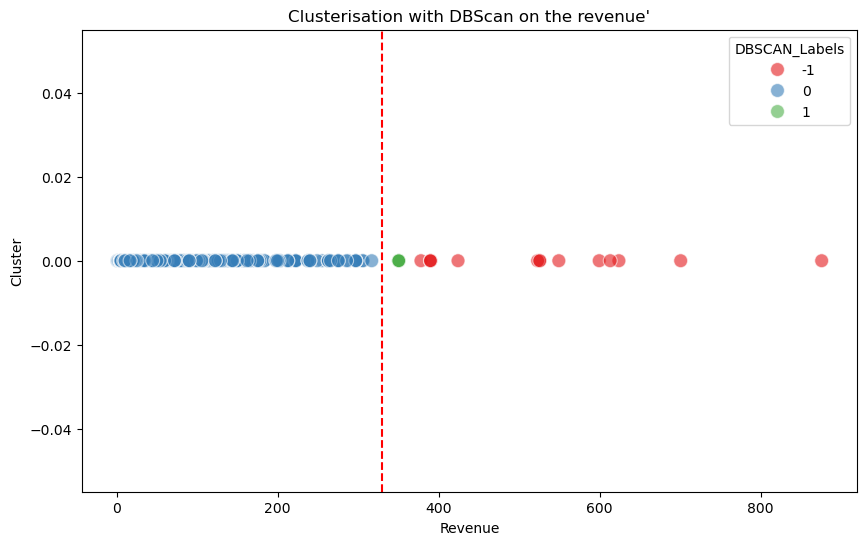

In [685]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)
df1['DBSCAN_Labels'] = labels_dbscan #we add the DBSCAN_labels to the dataframe to use them later
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df1['Revenue'], y=[0]*len(df1), hue=df1['DBSCAN_Labels'], palette='Set1', s=100, alpha=0.6)
plt.axvline(x=330, color='red', linestyle='--', label='Revenue = 330') #this is where we will do our separation
plt.title("Clusterisation with DBScan on the revenue'")
plt.xlabel('Revenue')
plt.ylabel('Cluster')
plt.show()

Use of the Mean shift model

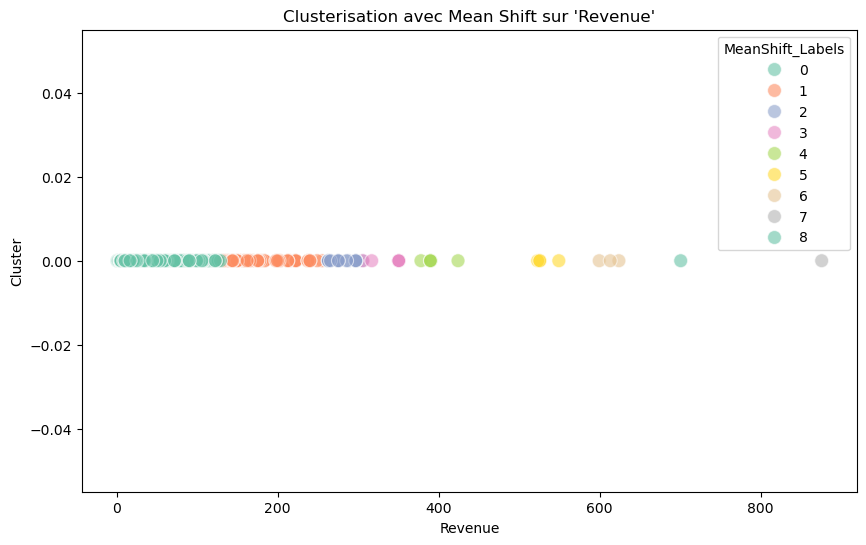

In [671]:
meanshift = MeanShift(bandwidth=1.0)
labels_meanshift = meanshift.fit_predict(X_scaled)
df1['MeanShift_Labels'] = labels_meanshift #add labels to the dataframe

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df1['Revenue'], y=[0]*len(df1), hue=df1['MeanShift_Labels'], palette='Set2', s=100, alpha=0.6)
plt.title("Clusterisation avec Mean Shift sur 'Revenue'")
plt.xlabel('Revenue')
plt.ylabel('Cluster')
plt.show()

Here we see that the clusterisation is very difficult to do via a model on this dataset. We will use DBScan here because there are two valuable categories.

By using the dbscan model we saw that there were three categories, however one of them (-1) represents the outliers. So we will take it out and use the two categories. Even if the clusterisation cannot really be done in a efficient way we will still use it and do classification with it to show the scope of our work

Here we see that this part of the dataframe has a lot of desequilibrium. However we have tested with a lot of parts of the dataset (use of another country, of a specific period) the distribution remained the same unfortunately.

For each model/hyperparametring, we calculate the metrics for the train and test for both categories to make out of it a complete assessment

Counts by cluster (without outliers):
DBSCAN_Labels
0    9002
1       9
Name: count, dtype: int64


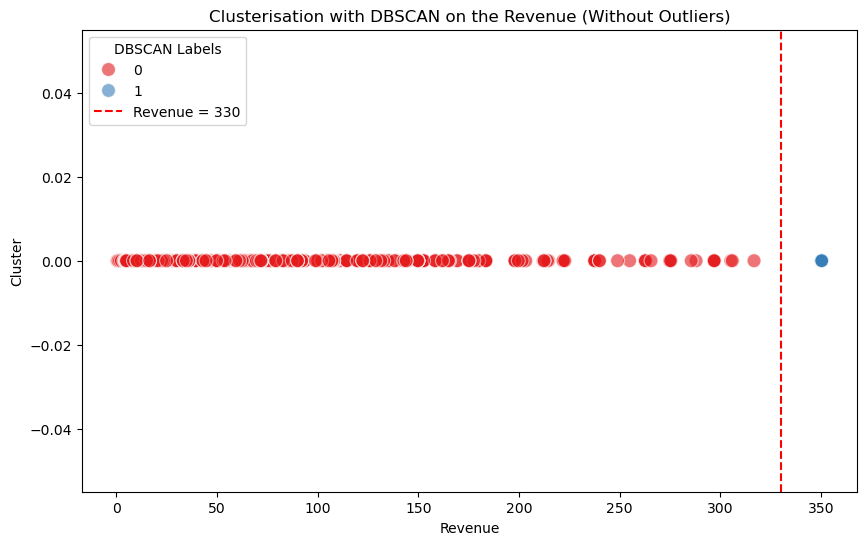

In [524]:
#standardisation
X = df1['Revenue'].values.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#application of the DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)
df1['DBSCAN_Labels'] = labels_dbscan  # Ajouter les labels DBSCAN au DataFrame

#take out outliers
df = df1[df1['DBSCAN_Labels'] != -1].copy()

# Compter les occurrences des clusters valides
counts = df['DBSCAN_Labels'].value_counts().sort_index()
print("Counts by cluster (without outliers):")
print(counts)

#graph without outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_no_outliers['Revenue'], 
                y=[0] * len(df_no_outliers), 
                hue=df_no_outliers['DBSCAN_Labels'], 
                palette='Set1', s=100, alpha=0.6)

plt.axvline(x=330, color='red', linestyle='--', label='Revenue = 330')  #separation line between the classes
plt.title("Clusterisation with DBSCAN on the Revenue (Without Outliers)")
plt.xlabel('Revenue')
plt.ylabel('Cluster')
plt.legend(title='DBSCAN Labels')
plt.show()


In [737]:
df1['RevenueClass'] = pd.cut(df1['Revenue'], bins=[df1['Revenue'].min(), 330, df1['Revenue'].max()],
                             labels=['Faible', 'Élevé'], include_lowest=True)

#preparation of the data for the training
X = embeddings
y = df1['RevenueClass']

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For each model/hyperparametring, we calculate the metrics for the train and test for both categories to make out of it a complete assessment

In [739]:
#file path
results_classif_file = "newresults.csv"

#charge or create the dataframe if it exists or not
if os.path.exists(results_classif_file):
    results_classif_df = pd.read_csv(results_classif_file)
else:
    results_classif_df = pd.DataFrame(columns=[
        "Type de modèle", "Hyperparamètres du modèle", "Temps d'entraînement", 
        "Temps d'inférence", "Précision train (Faible)", "Précision test (Faible)", 
        "Recall train (Faible)", "Recall test (Faible)", 
        "F1-Score train (Faible)", "F1-Score test (Faible)", 
        "Précision train (Élevé)", "Précision test (Élevé)", 
        "Recall train (Élevé)", "Recall test (Élevé)", 
        "F1-Score train (Élevé)", "F1-Score test (Élevé)"
    ])

#Evaluation of models
def evaluate_classification_model(model, x_train, y_train, x_test, y_test, model_name, params):
    global results_classif_df

    try:
        #training
        start_time = time.time()
        model.fit(x_train, y_train)
        training_time = time.time() - start_time

        #prediction on train and test
        start_time = time.time()
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        inference_time = time.time() - start_time

        #classification reports for train and test
        train_report = classification_report(y_train, y_train_pred, output_dict=True, target_names=["Faible", "Élevé"])
        test_report = classification_report(y_test, y_test_pred, output_dict=True, target_names=["Faible", "Élevé"])

        results = {
            "Type de modèle": model_name,
            "Hyperparamètres du modèle": params,
            "Temps d'entraînement": training_time,
            "Temps d'inférence": inference_time,
            "Précision train (Faible)": train_report["Faible"]["precision"],
            "Précision test (Faible)": test_report["Faible"]["precision"],
            "Recall train (Faible)": train_report["Faible"]["recall"],
            "Recall test (Faible)": test_report["Faible"]["recall"],
            "F1-Score train (Faible)": train_report["Faible"]["f1-score"],
            "F1-Score test (Faible)": test_report["Faible"]["f1-score"],
            "Précision train (Élevé)": train_report["Élevé"]["precision"],
            "Précision test (Élevé)": test_report["Élevé"]["precision"],
            "Recall train (Élevé)": train_report["Élevé"]["recall"],
            "Recall test (Élevé)": test_report["Élevé"]["recall"],
            "F1-Score train (Élevé)": train_report["Élevé"]["f1-score"],
            "F1-Score test (Élevé)": test_report["Élevé"]["f1-score"],
        }

        #add to dataframe
        results_classif_df = pd.concat([
            results_classif_df,
            pd.DataFrame([results])
        ], ignore_index=True)

        #save to csv
        results_classif_df.to_csv(results_classif_file, index=False)

    except Exception as e:
        print(f"Erreur lors de l'évaluation du modèle {model_name} avec les paramètres {params}: {e}")

#hyperparameters grid
param_grid = {
    "LogisticRegression": {
        "C": [0.001, 0.01, 0.1, 1.0],
        "penalty": ["l2"],
        "solver": ["liblinear", "lbfgs"],
        "class_weight": [None, "balanced"],
    },
    "MLPClassifier": {
        "hidden_layer_sizes": [(50,), (100,), (100, 50)],
        "activation": ["relu", "tanh"],
        "solver": ["adam", "sgd"],
        "alpha": [0.0001, 0.001, 0.01],
        "early_stopping": [True, False],
    }
}

#Initialisation
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
mlp_model = MLPClassifier(max_iter=1000, random_state=42)

#iteration for the hyperparameters grid part of LogisticRegression
for params in product(*param_grid["LogisticRegression"].values()):
    params_dict = dict(zip(param_grid["LogisticRegression"].keys(), params))
    logreg_model.set_params(**params_dict)
    evaluate_classification_model(logreg_model, X_train, y_train, X_test, y_test, "LogisticRegression", params_dict)

#iteration for the hyperparameters grid part of MLPClassifier
for params in product(*param_grid["MLPClassifier"].values()):
    params_dict = dict(zip(param_grid["MLPClassifier"].keys(), params))
    mlp_model.set_params(**params_dict)
    evaluate_classification_model(mlp_model, X_train, y_train, X_test, y_test, "MLPClassifier", params_dict)


Display of the results

In [743]:
results_classif_file = "newresults.csv"

if os.path.exists(results_classif_file):
    results_classif_df = pd.read_csv(results_classif_file)
else:
    results_classif_df = pd.DataFrame(columns=[
        "Type de modèle", "Hyperparamètres du modèle", "Temps d'entraînement", 
        "Temps d'inférence", 
        #low metrics for train and test
        "Précision (Faible) train", "Précision (Faible) test", 
        "Recall (Faible) train", "Recall (Faible) test", 
        "F1-Score (Faible) train", "F1-Score (Faible) test",
        #High metrics for train and test
        "Précision (Fort) train", "Précision (Fort) test", 
        "Recall (Fort) train", "Recall (Fort) test", 
        "F1-Score (Fort) train", "F1-Score (Fort) test"
    ])

#### Top 2 results for MLP Classifier

In [745]:
results_classif_df[results_classif_df["Type de modèle"] == "MLPClassifier"].sort_values(by="F1-Score test (Élevé)", ascending=False).head(2)

,Type de modèle,Hyperparamètres du modèle,Temps d'entraînement,Temps d'inférence,Précision train (Faible),Précision test (Faible),Recall train (Faible),Recall test (Faible),F1-Score train (Faible),F1-Score test (Faible),Précision train (Élevé),Précision test (Élevé),Recall train (Élevé),Recall test (Élevé),F1-Score train (Élevé),F1-Score test (Élevé)
16,MLPClassifier,"{'hidden_layer_sizes': (50,), 'activation': 'r...",0.519657,0.0,0.997645,0.996676,1.000000,1.000000,0.998821,0.998335,0.000000,0.0,0.000000,0.0,0.000000,0.0
17,MLPClassifier,"{'hidden_layer_sizes': (50,), 'activation': 'r...",1.110775,0.0,0.998198,0.996674,0.999584,0.999444,0.998890,0.998057,0.571429,0.0,0.235294,0.0,0.333333,0.0


#### Top 2 results for Logistic Regression

In [747]:
results_classif_df[results_classif_df["Type de modèle"] == "LogisticRegression"].sort_values(by="F1-Score test (Élevé)", ascending=False).head(2)

,Type de modèle,Hyperparamètres du modèle,Temps d'entraînement,Temps d'inférence,Précision train (Faible),Précision test (Faible),Recall train (Faible),Recall test (Faible),F1-Score train (Faible),F1-Score test (Faible),Précision train (Élevé),Précision test (Élevé),Recall train (Élevé),Recall test (Élevé),F1-Score train (Élevé),F1-Score test (Élevé)
3,LogisticRegression,"{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs...",0.074099,0.028416,0.999437,0.999434,0.985700,0.981656,0.992521,0.990466,0.112069,0.131579,0.764706,0.833333,0.195489,0.227273
1,LogisticRegression,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.266804,0.022400,0.999572,0.999425,0.971956,0.966092,0.985570,0.982476,0.064815,0.075758,0.823529,0.833333,0.120172,0.138889


Given the distribution of transactions in Germany during the calendar year 2010, it is clear that the metric values are biased, as such a distribution makes it easier for these models to perform classification.

##### We tried to do the same for Ireland (EIRE), but the result will be the same given the distribution...

In [622]:
df1 = pd.read_csv("Online_Retail.csv", sep=';', encoding='ISO-8859-1')
df1['UnitPrice'] = df1['UnitPrice'].astype(str).str.replace(',', '.').astype(float)
df1[df1['UnitPrice'] < 0]
df1['Revenue'] = df1['Quantity'] * df1['UnitPrice']
df1 = df1[df1['Description'].notnull()]
#df1 = df1[df1['InvoiceNo'].str[0] != 'C']
df1 = df1[df1['UnitPrice']>0]
df1 = df1[df1['Quantity']>0]
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'], format="%d/%m/%Y %H:%M")

#df1 = df1[(df1['InvoiceDate'] >= start_date) & (df1['InvoiceDate'] <= end_date)]
df1 = df1[df1['Country'] == 'EIRE']
description_counts = df1['Description'].value_counts()
descriptions_to_keep = description_counts[description_counts > 1].index
df1 = df1.drop_duplicates()
df1['Description'] = df1['Description'].replace(',', ' ', regex=True)
df1['CustomerID'] = df1['CustomerID'].fillna(-1)
df1['CustomerID'] = df1['CustomerID'].astype(int)
# drop les customerID = -1
df1 = df1[df1['CustomerID'] != -1]
df1["CustomerID"] = df1["CustomerID"].astype(str).apply(lambda x: x.split('.')[0])
df1["InvoiceDate"] = pd.to_datetime(df1["InvoiceDate"], dayfirst=True).dt.date
counts = df1['Country'].value_counts()
print(counts)


Country
EIRE    7226
Name: count, dtype: int64


In [623]:
counts = df1['Country'].value_counts()
print(counts)


Country
EIRE    7226
Name: count, dtype: int64


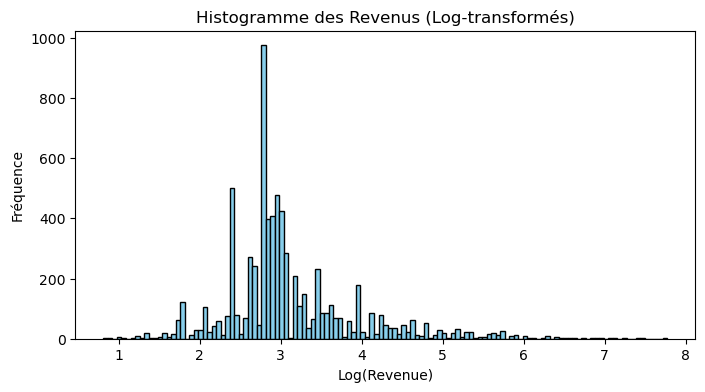

In [624]:
#logarithmic transformation on the Revenue of the November and December revenues of the UK
df1['LogRevenue'] = np.log(df1['Revenue'] + 1)  # Add of 1 to avoid log(0)
#We plot the histogram with 125 bins
plt.figure(figsize=(8,4))
plt.hist(df1['LogRevenue'], bins=125, color='skyblue', edgecolor='black')
plt.title('Histogramme des Revenus (Log-transformés)')
plt.xlabel('Log(Revenue)')
plt.ylabel('Fréquence')
plt.show()

In [625]:
X = df1['Revenue'].values.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Nombre de valeurs par catégorie de labels DBSCAN :
Class -1: 15 rows
Class 0: 7184 rows
Class 1: 12 rows
Class 2: 8 rows
Class 3: 7 rows


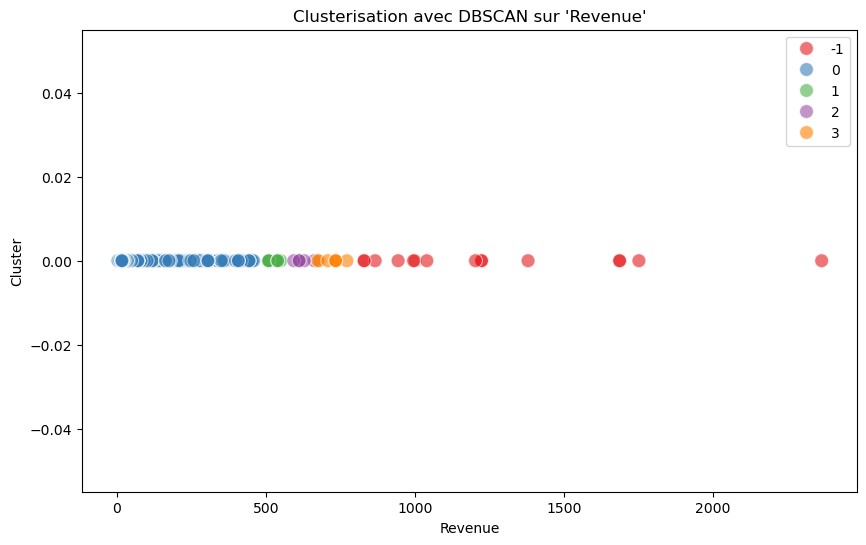

In [634]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)
df1['DBSCAN_Labels'] = labels_dbscan
label_counts = df1['DBSCAN_Labels'].value_counts().sort_index()
print("Nombre de valeurs par catégorie de labels DBSCAN :")
for label, count in label_counts.items():
    print(f"Class {label}: {count} rows")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df1['Revenue'], y=[0]*len(df1), hue=df1['DBSCAN_Labels'], palette='Set1', s=100, alpha=0.6)
plt.title("Clusterisation avec DBSCAN sur 'Revenue'")
plt.xlabel('Revenue')
plt.ylabel('Cluster')
plt.legend()
plt.show()

With the distribution, the use of the model which worked before, We see again that the desequilibrium is still enormous between the categories with such a dataset unfortunately... which confirms the fact that the clusterisation via models for our dataset before doing classification is not possible unfortunately.